In [1]:
# Simulation imports
from reporting import simulation
from reporting.plot_outbreak import plot_outbreak

In [2]:
# Library imports
import geopandas
import matplotlib
import shapely
import numpy as np
from matplotlib import pyplot

# Set default plot size
matplotlib.rcParams['figure.figsize'] = [16.0, 12.0]




# Day 1
## All the field reports have come in and it's time to analyse them

In [3]:
simulation.gather_reports_for_day_1()

### Let's grab the data directly from the database

In [4]:
from psycopg2 import connect
connection = connect(dbname='johnsnow')
cases = geopandas.read_postgis(
    "select * from reporting_report", connection,
    geom_col='location',
    crs={'init': 'epsg:4326'}  # The most widely used spatial reference system
)


- `cases` is a Geopandas `GeoDataFrame`
- This is just like a regular `DataFrame` except that it has to have a `GeoSeries` column containing spatial data
- we have lots of interesting new spatial methods that will act on this geometry column


In [5]:
cases[['doctor_name', 'patient_name', 'diagnosis', 'location']].sample(5)

,doctor_name,patient_name,diagnosis,location
54,John Cervantes,Connie Okelly,rubella,POINT (-0.1101442576228033 51.49764209254286)
26,Dana Thompson,Karen Groves,typhoid,POINT (-0.1229411331309719 51.52256931993506)
48,Christy Anglemyer,Sharon Gunn,smallpox,POINT (-0.1095287226347265 51.49742069434558)
43,Elizabeth Jones,Deborah Seigel,typhoid,POINT (-0.08580941021292392 51.53391837143516)
30,Michelle Jackson,Rolando Wardlow,rubella,POINT (-0.1219798545333925 51.52202486966652)


### Let's visualise

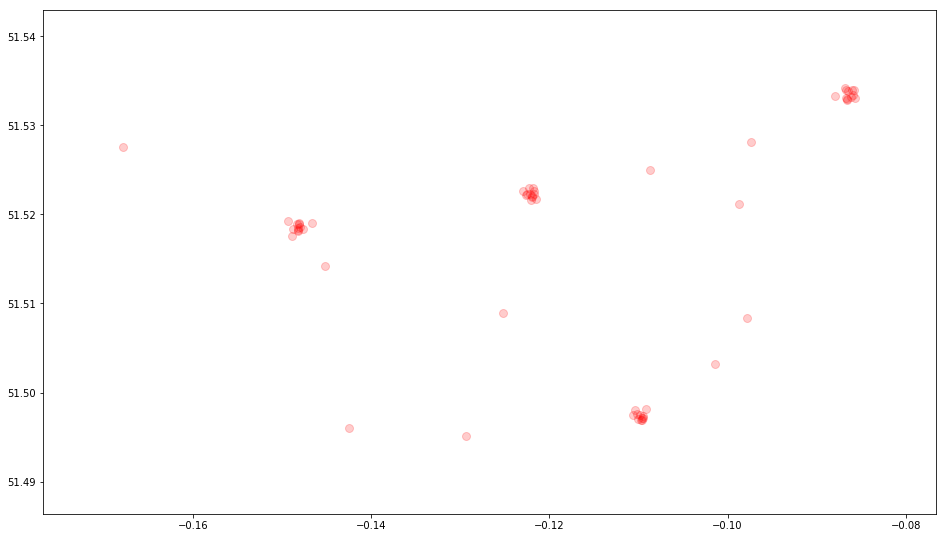

In [6]:
cases.plot(marker="o", color="red", markersize=64, alpha=0.2)

### This looks scary
- We have obvious clusters of diagnoses

### Let's distinguish different diagnoses

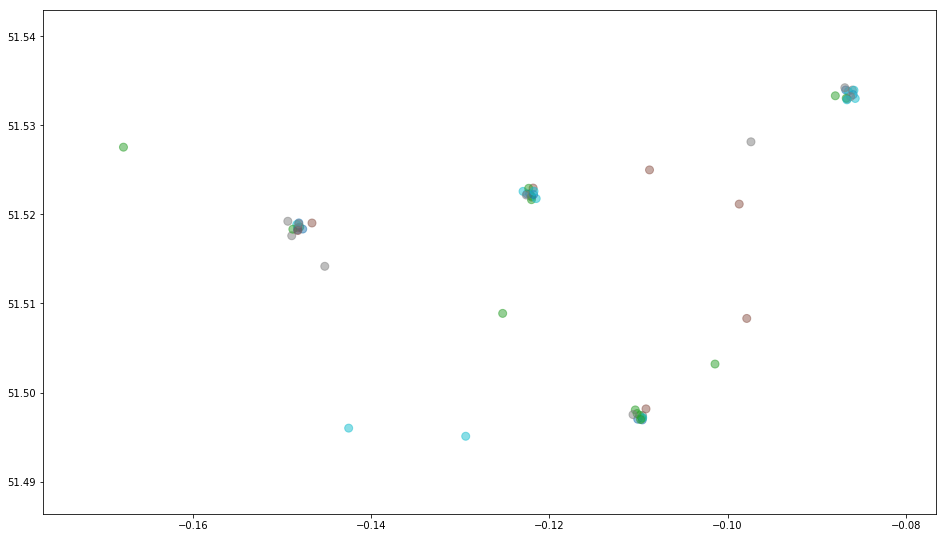

In [7]:
plot = cases.plot(marker="o", markersize=64, alpha=0.5, column='diagnosis')

### This situation doesn't look right
- Each cluster has many different diseases diagnosed within it.

### This data is useless without context. Let's map it
- We will import "Shapefiles" from the Open Street Map project
- Shapefiles are a very common format for sharing spatial data along with facts about objects
- You can say:
  - This is a road
  - It has a shape
  - It has a name: "Oxford Street"
  - It's classified as a B-Road

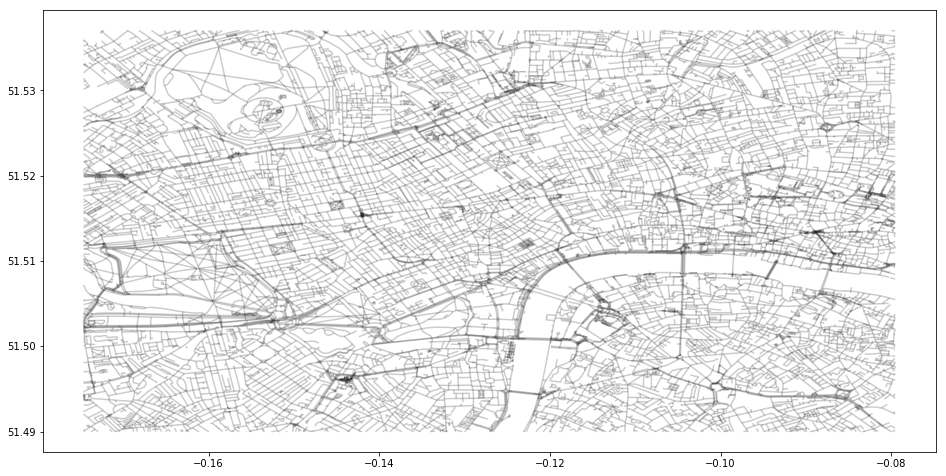

In [8]:
# Import London's roads
roads = geopandas.read_file('../open-street-map-data/london-roads_shp/')
roads.plot(color="black", alpha=0.2)

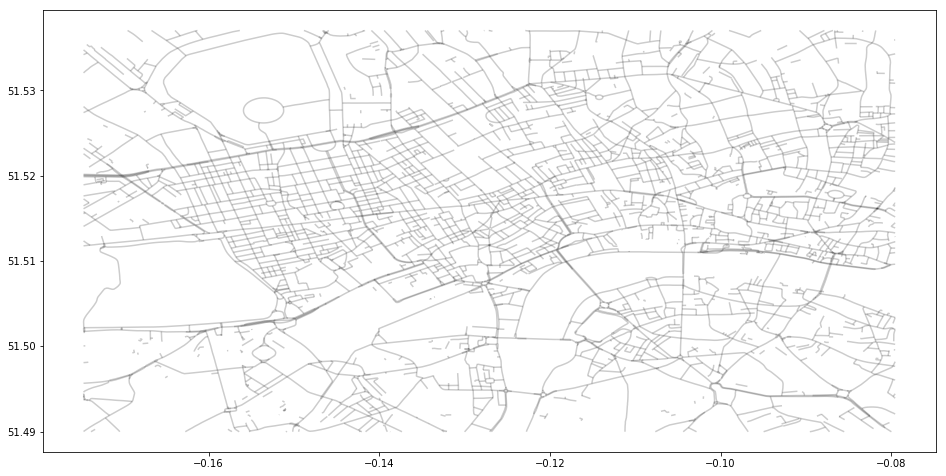

In [9]:
# Filter roads by type
mains = roads[roads['highway'].isin(('trunk', 'primary', 'secondary', 'tertiary', 'unclassified'))]
mains.plot(color="black", alpha=0.2)

In [10]:
# Import London's rivers
rivers = geopandas.read_file('../open-street-map-data/london-rivers_shp/')

Let's use that extra data to filter the shapes we've imported:

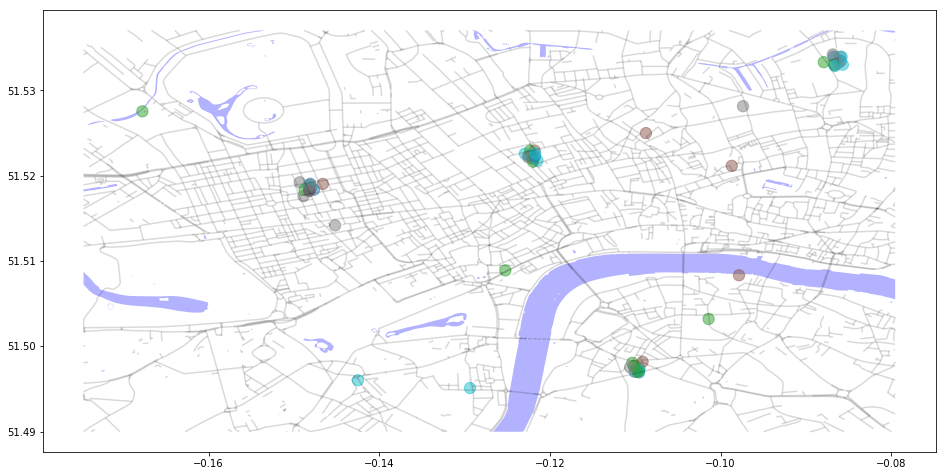

In [11]:
# Draw all three datasets on one axis to make a map
figure, axes = pyplot.subplots()

rivers.plot(ax=axes, color='blue', alpha=0.3)
mains.plot(ax=axes, color="black", alpha=0.15)
cases.plot(ax=axes, marker="o", column="diagnosis", markersize=128, alpha=0.5)

pyplot.show()

### What's going on? I have a hunch...

In [12]:
# Let's get open street map data about medical facilities
medical = geopandas.read_file('../open-street-map-data/london-hospitals_shp/')

# And use pandas filtering to select only the hospitals
hospitals = medical[medical['amenity'] == 'hospital'].copy()

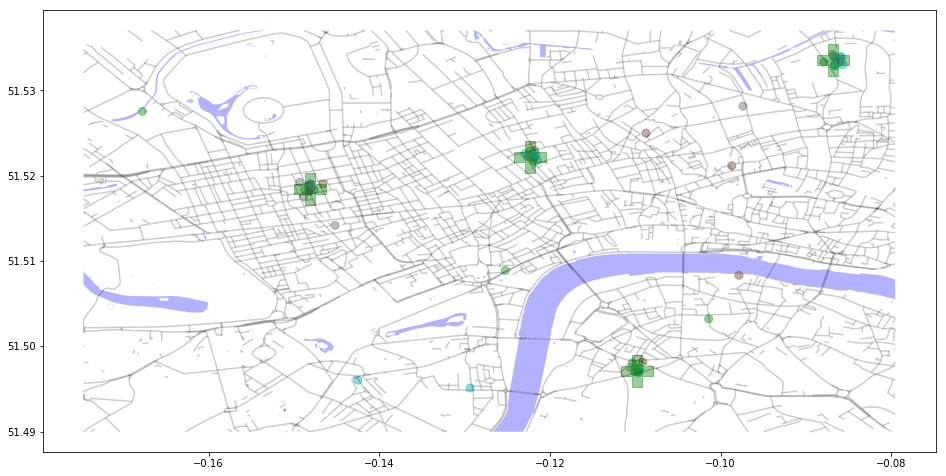

In [13]:
# Overlay our various geo-datasets
figure, axes = pyplot.subplots()
rivers_plot = rivers.plot(ax=axes, color='blue', alpha=0.3)
map_plot = mains.plot(ax=axes, color="black", alpha=0.2)
cases_plot = cases.plot(ax=axes, marker="o", column="diagnosis", markersize=64, alpha=0.5)

# Plot a green cross at the location of each hospital
final = hospitals.plot(ax=axes, marker="P", markersize=1000, color="green", alpha=0.4)

pyplot.show()

### We need to improve our analysis

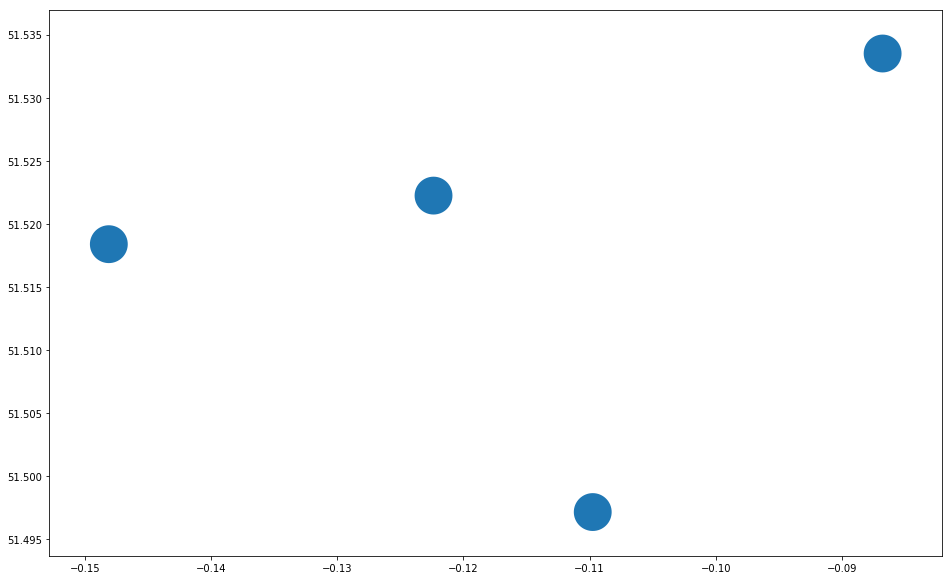

In [14]:
# Create a polygon representing about 150m around each hospital
hospitals['geometry'] = hospitals['geometry'].buffer(0.0015)
hospitals.plot()

![Joins](spatial-join.png)

In [15]:
# Join together the hospital zones with the cases
# The "join" is a spatial one - we are joining cases with the hospitals that they are close to
joined_cases = geopandas.sjoin(
    left_df=cases,
    right_df=hospitals,
    how='left',
    op='within',
)

In [16]:
# Now each case that happened in a hospital is associated with the relevant hospital
joined_cases[['doctor_name', 'patient_name', 'diagnosis', 'name']].sample(10)

,doctor_name,patient_name,diagnosis,name
39,Martin Tinsley,Catherine Welty,smallpox,The Hoxton Surgery
16,Eleanor Daigle,Dolores Nickl,typhoid,NaN
27,Thomas Neal,George Redman,smallpox,National Hospital for Neurology and Neurosurgery
31,Patricia Soledad,Gregory Jones,typhoid,National Hospital for Neurology and Neurosurgery
23,Scott Bilyeu,Michael Walser,cholera,National Hospital for Neurology and Neurosurgery
30,Michelle Jackson,Rolando Wardlow,rubella,National Hospital for Neurology and Neurosurgery
19,Phoebe Hamrick,Iris Messenger,rubella,NaN
29,Roberto Petix,Jenny Truocchio,rubella,National Hospital for Neurology and Neurosurgery
48,Christy Anglemyer,Sharon Gunn,smallpox,Cambian Churchill
17,Cynthia Hamer,Christopher White,rubella,NaN


### Let's find cases that didn't happen at hospitals

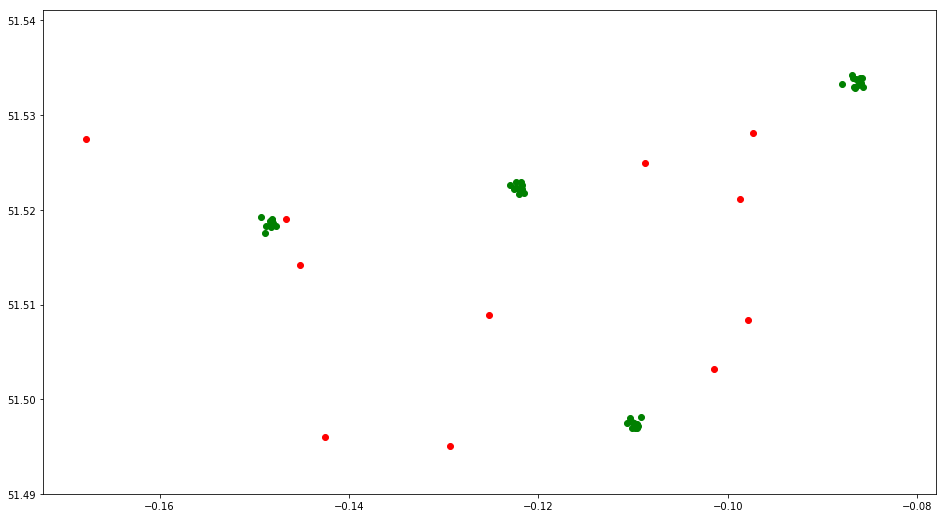

In [17]:
hospital_cases = joined_cases[~joined_cases['name'].isnull()]
non_hospital_cases = joined_cases[joined_cases['name'].isnull()]

axes = hospital_cases.plot(color="green")
non_hospital_cases.plot(ax=axes, color="red")


### And let's pull everything together

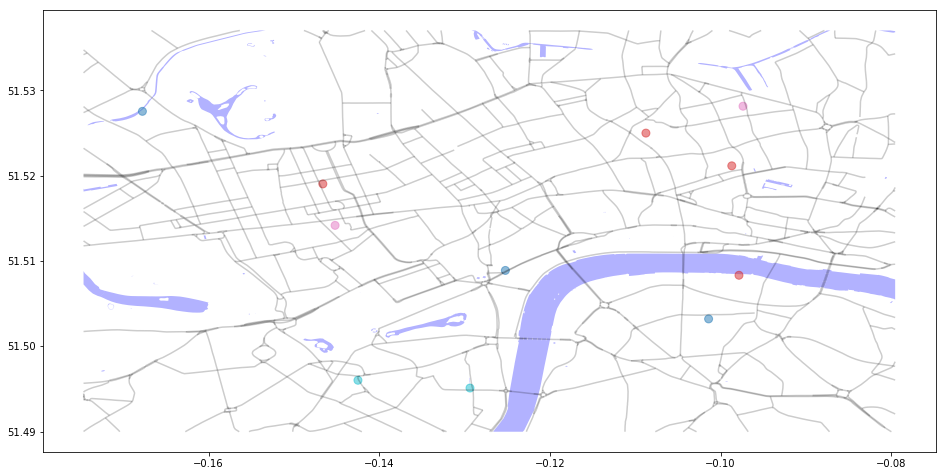

In [18]:
plot_outbreak()

# Day 2
### Not so peaceful

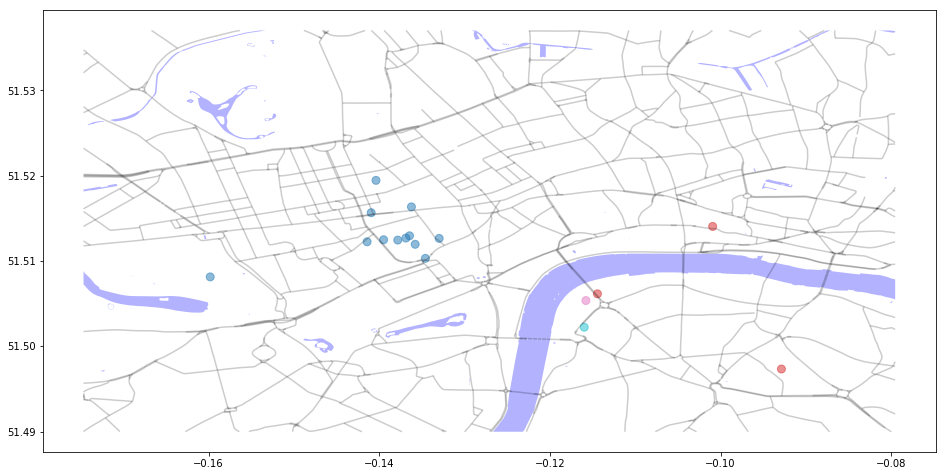

In [19]:
simulation.gather_reports_for_day_2()
plot_outbreak()

### If I was John Snow, I would investigate...

# Day 3

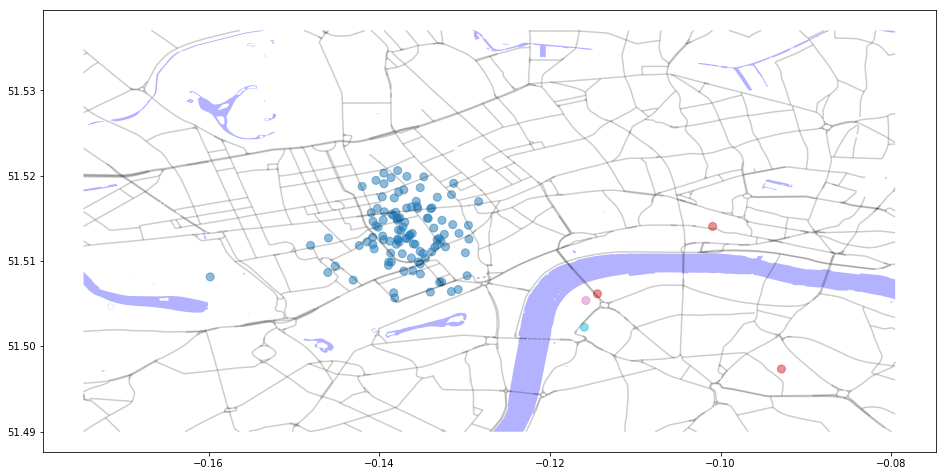

In [20]:
simulation.gather_reports_for_day_3()
plot_outbreak()

# 28 days later

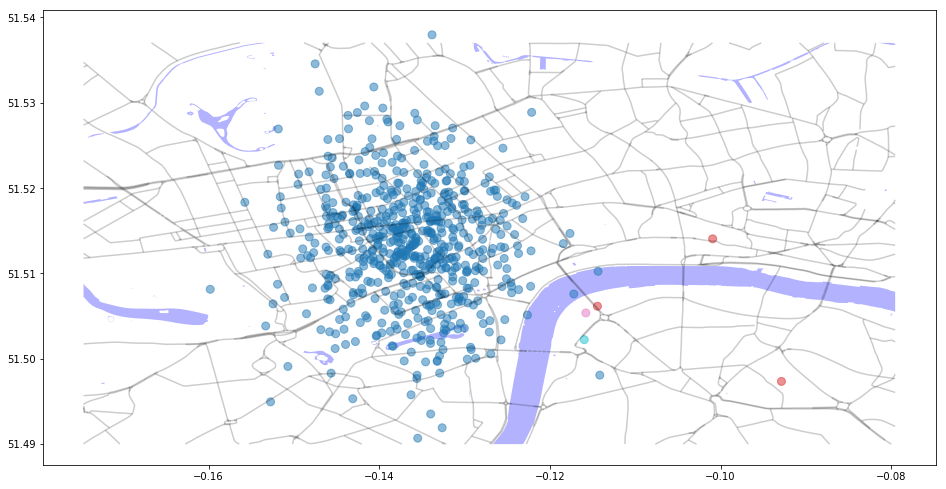

In [21]:
simulation.gather_reports_for_day_28()
plot_outbreak()